In [1]:
import geopandas as gpd
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pykrige.ok import OrdinaryKriging
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error
import random
import statsmodels.api as sm
from scipy.interpolate import NearestNDInterpolator

In [2]:
from global_land_mask import globe

In [3]:
ds = xr.open_dataset('C:/Users/Acer/Documents/SchoolHard/Thesis/Code/dataset//chl_merged_2002_08_2022_10.nc')

In [4]:
ds

<xarray.Dataset>
Dimensions:  (time: 243, lat: 51, lon: 33, rgb: 3, eightbitcolor: 256)
Coordinates:
  * lat      (lat) float32 7.729 7.687 7.646 7.604 ... 5.771 5.729 5.687 5.646
  * lon      (lon) float32 125.2 125.2 125.3 125.3 ... 126.4 126.4 126.5 126.5
  * time     (time) datetime64[ns] 2002-08-01 2002-09-01 ... 2022-10-01
Dimensions without coordinates: rgb, eightbitcolor
Data variables:
    chlor_a  (time, lat, lon) float32 ...
    palette  (time, rgb, eightbitcolor) uint8 ...
Attributes: (12/62)
    product_name:                     AQUA_MODIS.20020801_20020831.L3m.MO.CHL...
    instrument:                       MODIS
    title:                            MODISA Level-3 Standard Mapped Image
    project:                          Ocean Biology Processing Group (NASA/GS...
    platform:                         Aqua
    source:                           satellite observations from MODIS-Aqua
    ...                               ...
    cdm_data_type:                    grid
    keywords:                         Earth Science > Oceans > Ocean Chemistr...
    keywords_vocabulary:              NASA Global Change Master Directory (GC...
    data_bins:                        17371971
    data_minimum:                     0.0031615312
    data_maximum:                     86.2636

In [5]:
#define time steps, 243 monthly observations
start_date = pd.Timestamp('2002-08-01')
end_date = pd.Timestamp('2022-10-01')

#Create a new time coordinate that represents the month and year
time_coords = pd.date_range(start=start_date, end=end_date, freq='MS')

In [6]:
n = 24
samples = random.sample(list(time_coords), n)


In [7]:
#Define the number of folds for cross validation
n_splits = 3

In [8]:
#Create a KFold object to split the data
kf = KFold(n_splits=n_splits)

In [9]:
#metrics list
mse_list = []
rmse_list = []
mae_list = []
residual_list = np.array([])
interp_list = np.array([])

set: 0


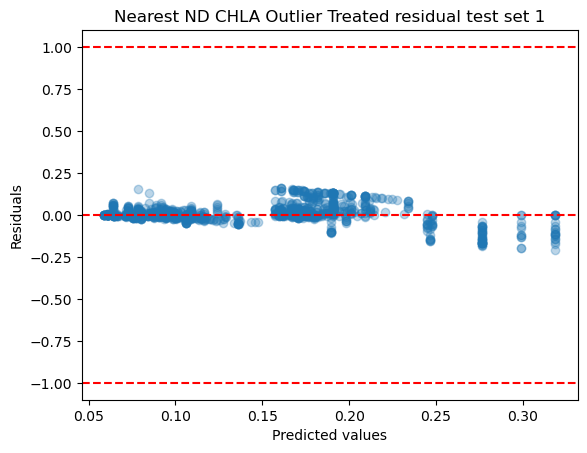

set: 1


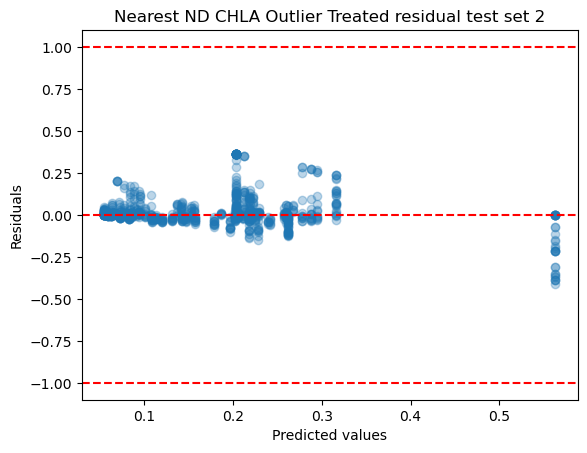

set: 2


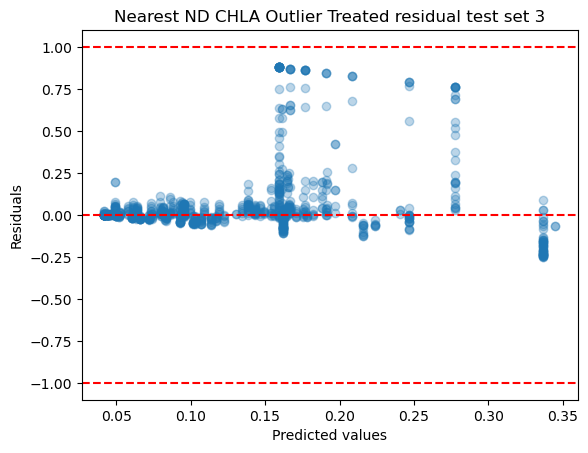

set: 3


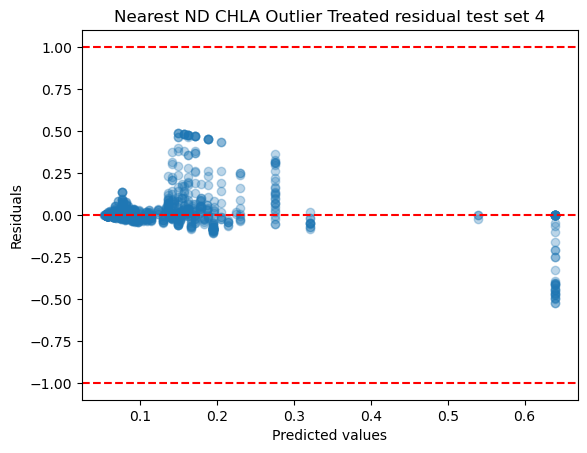

set: 4


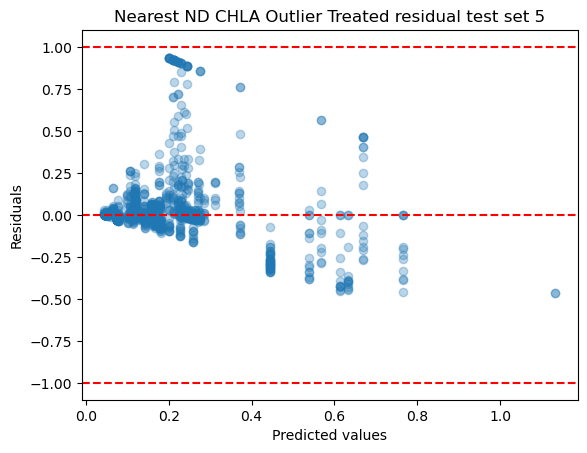

set: 5


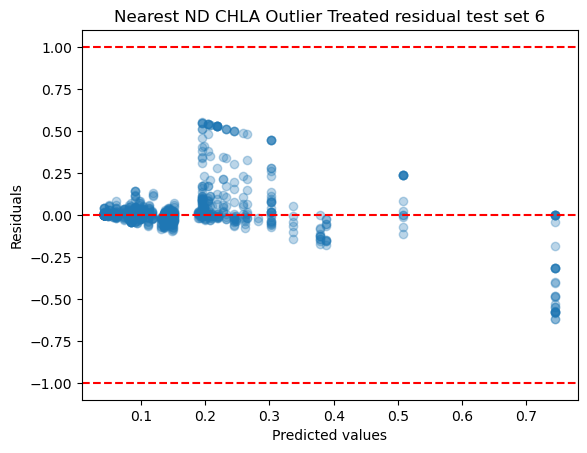

set: 6


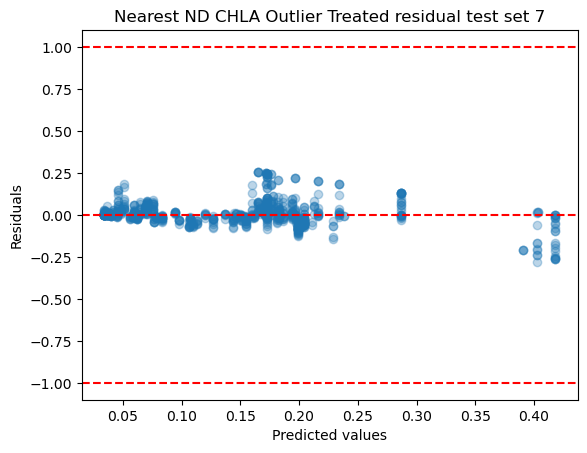

set: 7


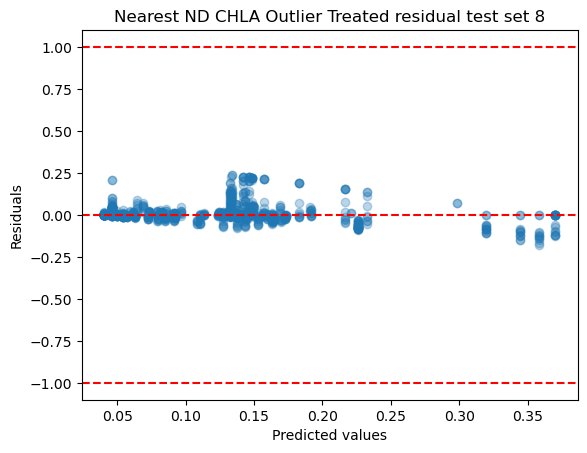

set: 8


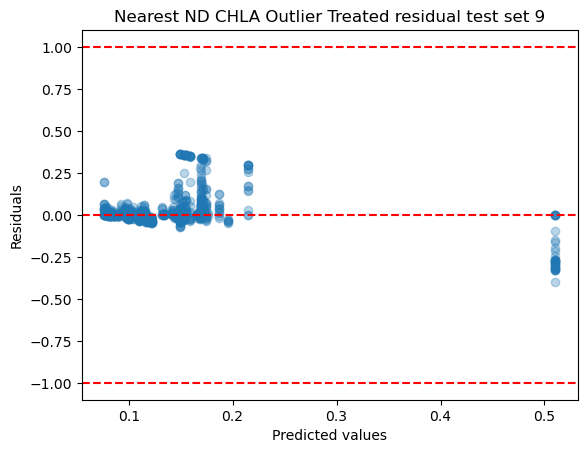

set: 9


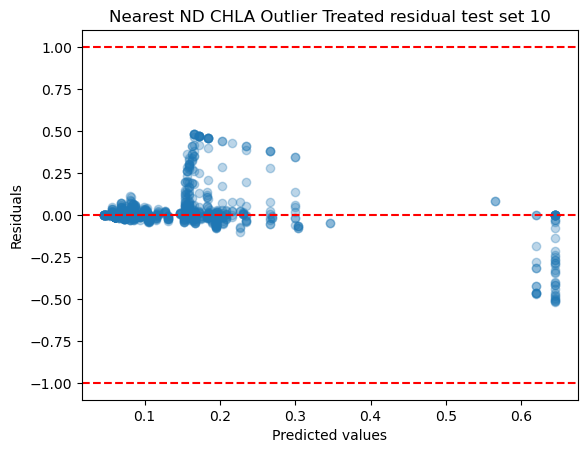

set: 10


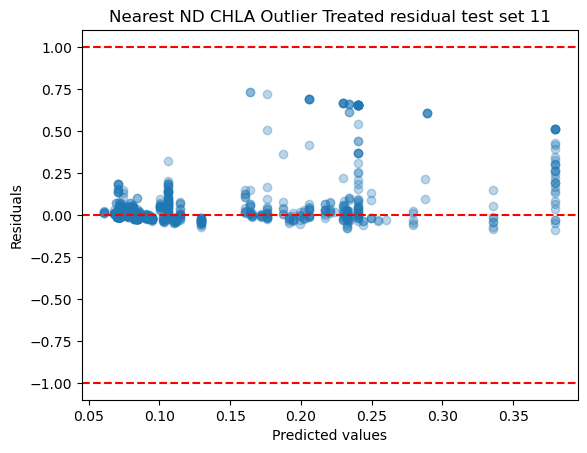

set: 11


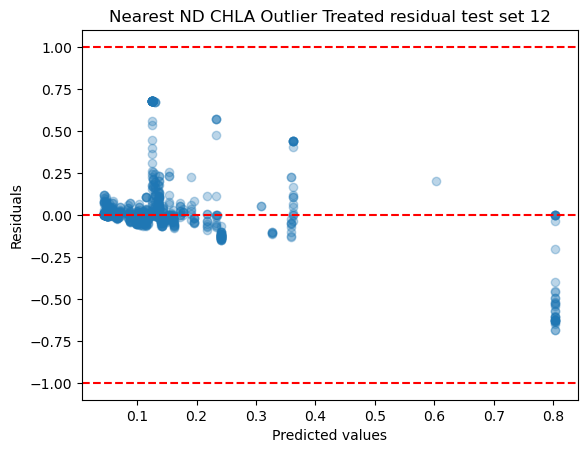

set: 12


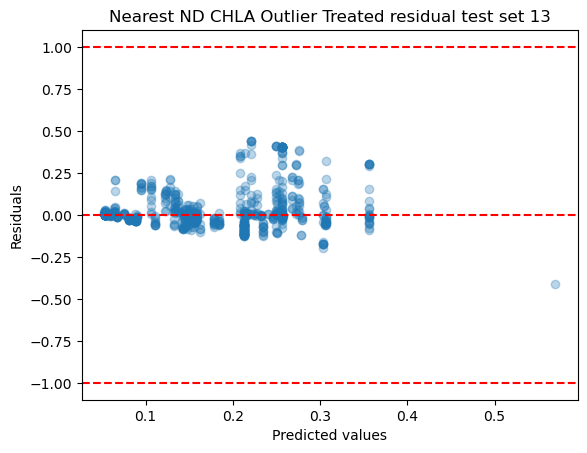

set: 13


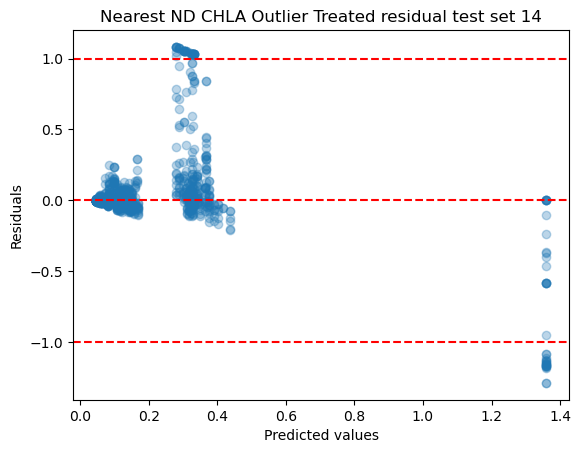

set: 14


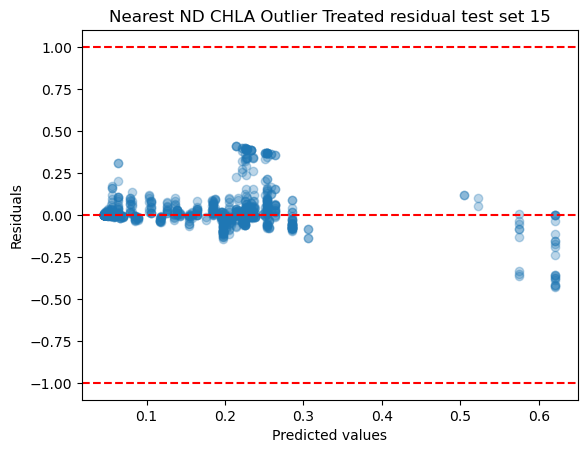

set: 15


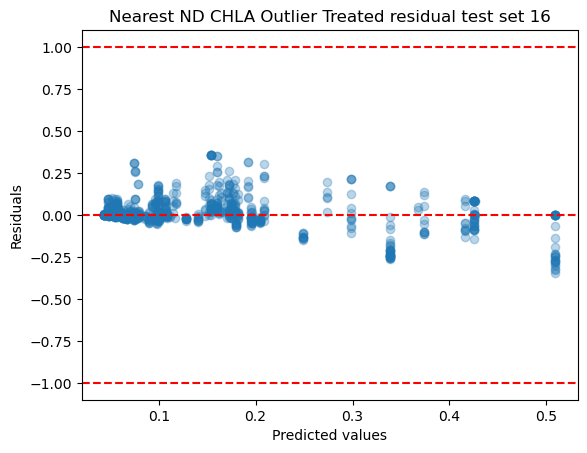

set: 16


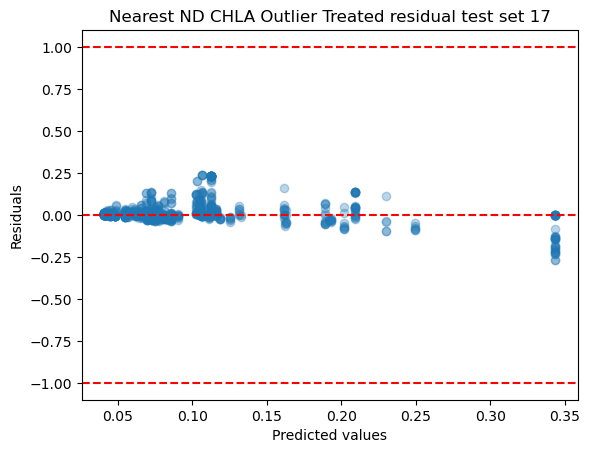

set: 17


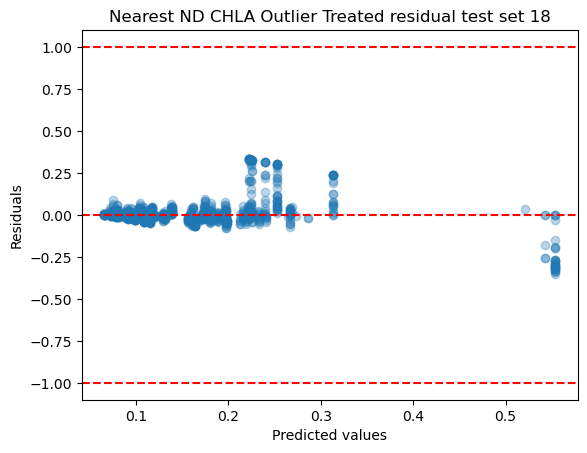

set: 18


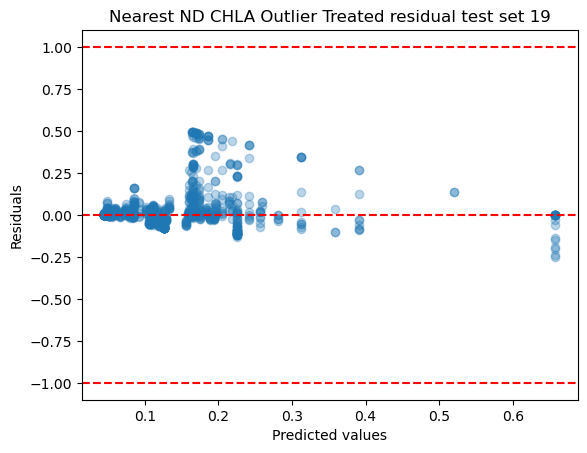

set: 19


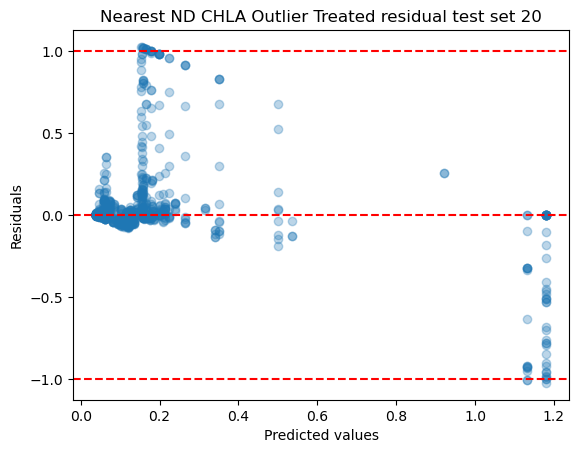

set: 20


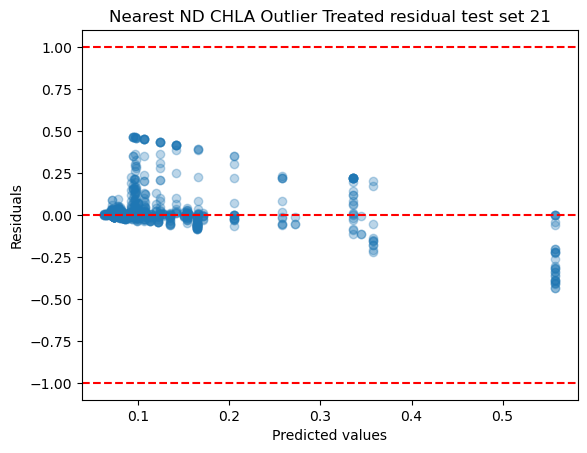

set: 21


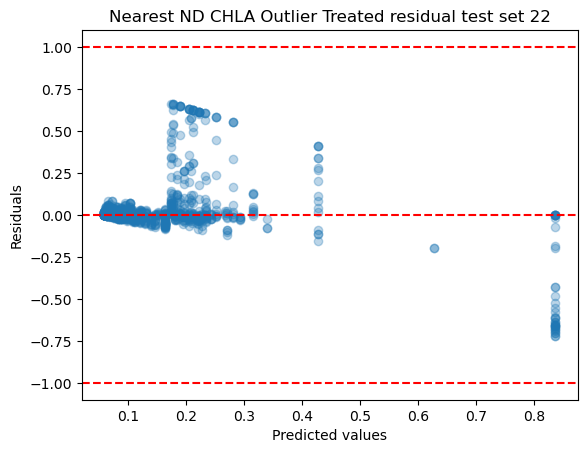

set: 22


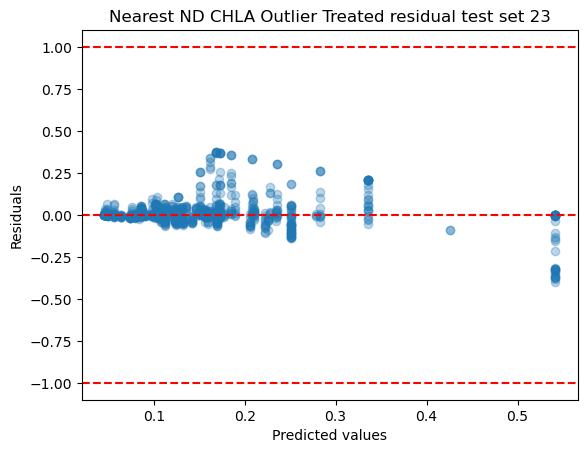

set: 23


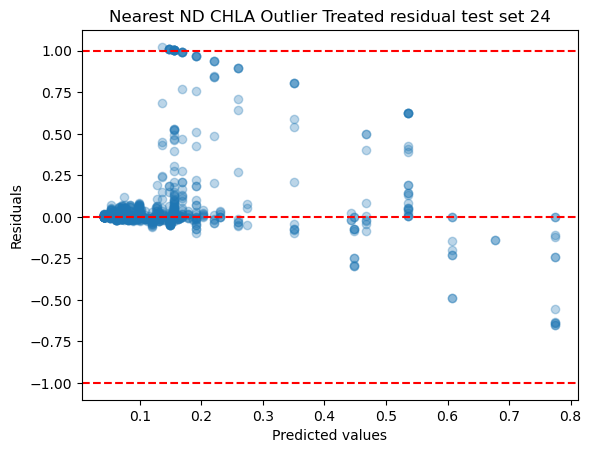

In [14]:
#NEAREST NEIGHBOR DISTANCE
for t in range(len(samples)):
    
    print('set: ' + str(t))
    
    monthly_data = ds['chlor_a'].sel(time= samples[t])
    lon = monthly_data['lon'].values
    lat = monthly_data['lat'].values
    
    #Convert the dataset to a pandas dataframe
    df = monthly_data.to_dataframe().reset_index()
    
    #convert dataframe to geodataframe 
    gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.lon, df.lat))
    
    #SET CRS to WGS84
    gdf.crs = 'WGS84'
    
    #dropna in gdf
    gdf = gdf.dropna()
    
    # Calculate winsorized values
    winsorized = np.clip(gdf['chlor_a'], gdf['chlor_a'].quantile(0.05), gdf['chlor_a'].quantile(0.95))

    # Define Huber loss function
    def huber_loss(residuals, c=1.345):
        return np.where(abs(residuals) < c, 0.5 * residuals ** 2, c * (abs(residuals) - 0.5 * c))

    # Define M-estimator function
    def m_estimator(data, loss_function, tuning_param):
        # Add a constant column to serve as the intercept
        exog = sm.add_constant(data)
        model = sm.RLM(gdf['chlor_a'], exog=exog, M=sm.robust.norms.HuberT(t=tuning_param))
        results = model.fit()
        return results.fittedvalues

    # Apply M-estimator function to winsorized data
    final_values = m_estimator(winsorized, huber_loss, 1.345)

    # Add final values as a new column to your original GeoDataFrame
    gdf['chlor_a'] = final_values

    # Convert the 'final_values' column to float data type if necessary
    gdf['chlor_a'] = gdf['chlor_a'].astype(float)
    
    #Get x, y, z values - this is the lon, lat, and variable/sst
    x = gdf.geometry.x
    y = gdf.geometry.y
    z = gdf['chlor_a']
    
    x_grid = np.linspace(lon.min(), lon.max(), num=100)
    y_grid = np.linspace(lat.min(), lat.max(), num=100)
    XI, YI = np.meshgrid(x_grid, y_grid)
    
    for train_index, test_index in kf.split(gdf):
        #Train and Test splits
        train_gdf = gdf.iloc[train_index].reset_index()
        test_gdf = gdf.iloc[test_index].reset_index()

        #Train data x,y,z
        x_train = train_gdf.geometry.x
        y_train = train_gdf.geometry.y
        z_train = train_gdf['chlor_a']

        #Ordinary Kriging
        #orkrig = OrdinaryKriging(x_train, y_train, z_train, variogram_model="linear", verbose=False, enable_plotting=False)
        nn_interpolator = NearestNDInterpolator(list(zip(x_train, y_train)), z_train)

        
        #Train data x,y,z
        x_test = test_gdf.geometry.x
        y_test = test_gdf.geometry.y
        z_test = test_gdf['chlor_a']

        # ZI_test = np.zeros_like(x_test)
        # for i in range(len(x_test)):
        #     ZI_test[i], sigma = orkrig.execute("grid", x_test[i], y_test[i])
        ZI_test = nn_interpolator(list(zip(x_test, y_test)))
        
        #Calculate residuals
        residuals = z_test - ZI_test
        
        residual_list = np.append(residual_list, residuals)
        interp_list = np.append(interp_list, ZI_test)

        #MSE -mean squared error
        mse = mean_squared_error(z_test, ZI_test)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(z_test, ZI_test)
    
        mse_list.append(mse)
        rmse_list.append(rmse)
        mae_list.append(mae)
    
    plt.scatter(interp_list, residual_list, alpha= 0.3)
    plt.axhline(y=0, color='red', linestyle='--')
    plt.axhline(y=1, color='red', linestyle='--')
    plt.axhline(y=-1, color='red', linestyle='--')
    plt.xlabel('Predicted values')
    plt.ylabel('Residuals')
    plt.title('Nearest ND CHLA Outlier Treated residual test set ' + str(t + 1))
    plt.show()
    plt.close()
    residual_list = []
    interp_list = []
    

In [15]:
# Compute the mean  of MSE MAE RMSE across all folds
mean_mse = np.mean(mse_list)
std_mse = np.std(mse_list)

mean_rmse = np.mean(rmse_list)
std_rmse = np.std(rmse_list)

mean_mae = np.mean(mae_list)
std_mae = np.std(mae_list)

print(mean_mse)
print(mean_rmse)
print(mean_mae)

0.02718144864078009
0.12652664734883345
0.07339249651077076


In [16]:
#metrics list
mse_list = []
rmse_list = []
mae_list = []
residual_list = np.array([])
interp_list = np.array([])

set: 0


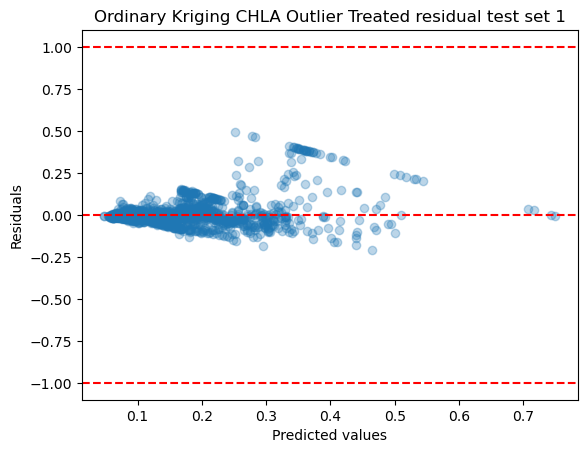

set: 1


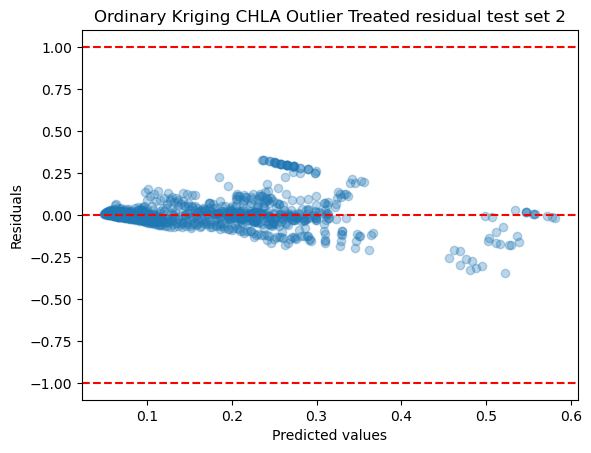

set: 2


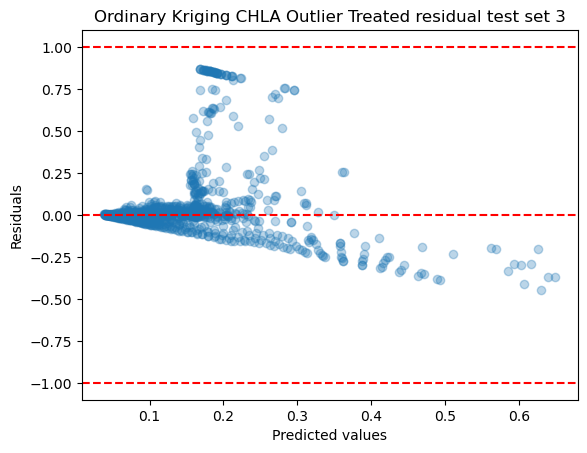

set: 3


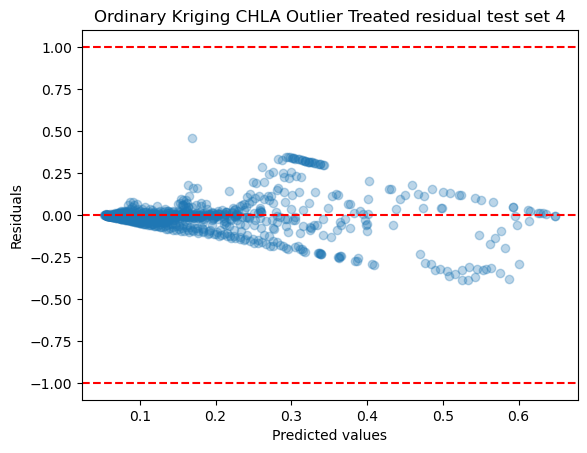

set: 4


KeyboardInterrupt: 

In [18]:
#ORDINARY KRIGING
for t in range(len(samples)):
    
    print('set: ' + str(t))
    
    monthly_data = ds['chlor_a'].sel(time= samples[t])
    lon = monthly_data['lon'].values
    lat = monthly_data['lat'].values
    
    #Convert the dataset to a pandas dataframe
    df = monthly_data.to_dataframe().reset_index()
    
    #convert dataframe to geodataframe 
    gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.lon, df.lat))
    
    #SET CRS to WGS84
    gdf.crs = 'WGS84'
    
    #dropna in gdf
    gdf = gdf.dropna()
    
    # Calculate winsorized values
    winsorized = np.clip(gdf['chlor_a'], gdf['chlor_a'].quantile(0.05), gdf['chlor_a'].quantile(0.95))

    # Define Huber loss function
    def huber_loss(residuals, c=1.345):
        return np.where(abs(residuals) < c, 0.5 * residuals ** 2, c * (abs(residuals) - 0.5 * c))

    # Define M-estimator function
    def m_estimator(data, loss_function, tuning_param):
        # Add a constant column to serve as the intercept
        exog = sm.add_constant(data)
        model = sm.RLM(gdf['chlor_a'], exog=exog, M=sm.robust.norms.HuberT(t=tuning_param))
        results = model.fit()
        return results.fittedvalues

    # Apply M-estimator function to winsorized data
    final_values = m_estimator(winsorized, huber_loss, 1.345)

    # Add final values as a new column to your original GeoDataFrame
    gdf['chlor_a'] = final_values

    # Convert the 'final_values' column to float data type if necessary
    gdf['chlor_a'] = gdf['chlor_a'].astype(float)
    
    #Get x, y, z values - this is the lon, lat, and variable/sst
    x = gdf.geometry.x
    y = gdf.geometry.y
    z = gdf['chlor_a']
    
    x_grid = np.linspace(lon.min(), lon.max(), num=100)
    y_grid = np.linspace(lat.min(), lat.max(), num=100)
    XI, YI = np.meshgrid(x_grid, y_grid)
    
    for train_index, test_index in kf.split(gdf):
        #Train and Test splits
        train_gdf = gdf.iloc[train_index].reset_index()
        test_gdf = gdf.iloc[test_index].reset_index()

        #Train data x,y,z
        x_train = train_gdf.geometry.x
        y_train = train_gdf.geometry.y
        z_train = train_gdf['chlor_a']

        #Ordinary Kriging
        orkrig = OrdinaryKriging(x_train, y_train, z_train, variogram_model="linear", verbose=False, enable_plotting=False)
        

        
        #Train data x,y,z
        x_test = test_gdf.geometry.x
        y_test = test_gdf.geometry.y
        z_test = test_gdf['chlor_a']

        ZI_test = np.zeros_like(x_test)
        for i in range(len(x_test)):
            ZI_test[i], sigma = orkrig.execute("grid", x_test[i], y_test[i])
            
        #Calculate residuals
        residuals = z_test - ZI_test
        
        residual_list = np.append(residual_list, residuals)
        interp_list = np.append(interp_list, ZI_test)
        

        #MSE -mean squared error
        mse = mean_squared_error(z_test, ZI_test)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(z_test, ZI_test)
    
        mse_list.append(mse)
        rmse_list.append(rmse)
        mae_list.append(mae)
    
    plt.scatter(interp_list, residual_list, alpha= 0.3)
    plt.axhline(y=0, color='red', linestyle='--')
    plt.axhline(y=1, color='red', linestyle='--')
    plt.axhline(y=-1, color='red', linestyle='--')
    plt.xlabel('Predicted values')
    plt.ylabel('Residuals')
    plt.title('Ordinary Kriging CHLA Outlier Treated residual test set ' + str(t + 1))
    plt.show()
    plt.close()
    residual_list = []
    interp_list = []
    

In [17]:
# Compute the mean  of MSE MAE RMSE across all folds
mean_mse = np.mean(mse_list)
std_mse = np.std(mse_list)

mean_rmse = np.mean(rmse_list)
std_rmse = np.std(rmse_list)

mean_mae = np.mean(mae_list)
std_mae = np.std(mae_list)

print(mean_mse)
print(mean_rmse)
print(mean_mae)

0.20631170881285515
0.2721890132379741
0.12352816023221513
